In [1]:
from train import DummyAgent
from evaluate import evaluate_HIV
from env_hiv import HIVPatient
from fast_env import FastHIVPatient
import torch

/home/pau/Documents/MVA-Paris/RL/mva-rl-assignment-paurm8/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


NameError: name 'AtariCNN' is not defined

In [17]:
# Check numpy version
import numpy as np
print(np.__version__)
# 2.0.0. 
# Write in requirements.txt file as 

2.0.0


In [7]:
agent = DummyAgent()

In [15]:
np

<module 'numpy' from '/home/pau/Documents/MVA-Paris/RL/mva-rl-assignment-paurm8/venv/lib/python3.10/site-packages/numpy/__init__.py'>

In [6]:
patient = HIVPatient()
agent = DummyAgent()
obs = patient.reset()
agent.act(obs)

1

In [ ]:
samples = []

In [9]:
import numpy as np
def get_samples(samples):
    S = np.array([s for (s, _, _) in samples])
    A = np.array([a for (_, a, _) in samples]).reshape(-1, 1)
    R = np.array([r for (_, _, r) in samples])
    return S, A, R

# Create random matrix to test this function
samples = []
for i in range(10):
    samples.append((np.random.rand(2), np.random.rand(1), np.random.rand(1)))

In [13]:
np.append([2, 3], 3)

array([2, 3, 3])

In [10]:
get_samples(samples)

(array([[0.4142207 , 0.74758638],
        [0.1966179 , 0.32111979],
        [0.67203264, 0.70414713],
        [0.5035823 , 0.59640967],
        [0.37695596, 0.80371767],
        [0.84180822, 0.15585505],
        [0.85675391, 0.2022218 ],
        [0.05235379, 0.94077421],
        [0.18883512, 0.41383688],
        [0.45957112, 0.29827577]]),
 array([[0.48873287],
        [0.91019971],
        [0.7745002 ],
        [0.07883959],
        [0.79106965],
        [0.42069763],
        [0.22082708],
        [0.20703543],
        [0.12854914],
        [0.26304538]]),
 array([[0.51673296],
        [0.13463783],
        [0.11545072],
        [0.48808802],
        [0.58527245],
        [0.27984822],
        [0.77295882],
        [0.6659192 ],
        [0.88129355],
        [0.75058949]]))

In [14]:
[x for x in zip(*samples)][0]

(array([0.4142207 , 0.74758638]),
 array([0.1966179 , 0.32111979]),
 array([0.67203264, 0.70414713]),
 array([0.5035823 , 0.59640967]),
 array([0.37695596, 0.80371767]),
 array([0.84180822, 0.15585505]),
 array([0.85675391, 0.2022218 ]),
 array([0.05235379, 0.94077421]),
 array([0.18883512, 0.41383688]),
 array([0.45957112, 0.29827577]))

In [8]:
from statistics import mean
from functools import partial
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

from env_hiv import HIVPatient
from interface import Agent


def evaluate_agent(agent: Agent, env: gym.Env, nb_episode: int = 10) -> float:
    """
    Evaluate an agent in a given environment.

    Args:
        agent (Agent): The agent to evaluate.
        env (gym.Env): The environment to evaluate the agent in.
        nb_episode (int): The number of episode to evaluate the agent.

    Returns:
        float: The mean reward of the agent over the episodes.
    """
    rewards: list[float] = []
    for _ in range(nb_episode):
        obs, info = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        while not done and not truncated:
            action = agent.act(obs)
            obs, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
        rewards.append(episode_reward)
    return mean(rewards)


evaluate_HIV = partial(
    evaluate_agent, env=TimeLimit(FastHIVPatient(), max_episode_steps=200)
)


evaluate_HIV_population = partial(
    evaluate_agent,
    env=TimeLimit(HIVPatient(domain_randomization=True), max_episode_steps=200),
)


In [1]:
100*200

20000

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import dqn_agent
from fast_env import FastHIVPatient
from gymnasium.wrappers import TimeLimit
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = TimeLimit(
    env=FastHIVPatient(domain_randomization=False), max_episode_steps=200
)

env_rand = TimeLimit(
    env=FastHIVPatient(domain_randomization=True), max_episode_steps=200
)

state_dim = env.observation_space.shape[0] + 1
n_action = env.action_space.n 
nb_neurons=10


DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

# DQN config
config = {'nb_actions': env.action_space.n,
          'learning_rate': 0.001, # Def: 0.001
          'gamma': 0.97, # Def: 0.95
          'buffer_size': 5000,
          'epsilon_min': 0.1,
          'epsilon_max': 1.,
          'epsilon_decay_period': 20000,
          'epsilon_delay_decay': 10000,
          'batch_size': 64,
          'gradient_steps': 1, # Def: 1
          'update_target_strategy': 'replace', # or 'ema'
          'update_target_freq': 1000, # Def 1000, crec???
          'update_target_tau': 0.005,
          'criterion': torch.nn.SmoothL1Loss(),
          'monitoring_nb_trials': 0}

agent = dqn_agent(config, DQN)

rewards, scores = agent.train(env_rand, 300)
plt.plot(np.log10(rewards), label="reward")
plt.figure()
plt.plot(np.log10(scores), label = "Scores")
plt.figure()

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Real score agent:  5.56E+06
Episode  1, epsilon   0.10, batch size 5000, ep return 2.93E+07
Episode  2, epsilon   0.10, batch size 5000, ep return 1.59E+07
Episode  3, epsilon   0.10, batch size 5000, ep return 4.11E+07
Episode  4, epsilon   0.10, batch size 5000, ep return 8.66E+07
Episode  5, epsilon   0.10, batch size 5000, ep return 2.90E+07
Real score agent:  6.38E+06
Episode  6, epsilon   0.10, batch size 5000, ep return 5.66E+07
Episode  7, epsilon   0.10, batch size 5000, ep return 5.48E+07
Episode  8, epsilon   0.10, batch size 5000, ep return 1.89E+07
Episode  9, epsilon   0.10, batch size 5000, ep return 4.91E+07
Episode 10, epsilon   0.10, batch size 5000, ep return 3.86E+07
Real score agent:  6.63E+06
Episode 11, epsilon   0.10, batch size 5000, ep return 4.68E+07
Episode 12, epsilon   0.10, batch size 5000, ep return 1.98E+07
Episode 13, epsilon   0.10, batch size 5000, ep return 6.70E+07
Episode 14, epsilon   0.10, batch size 5000, ep return 4.40E+07
Episode 15, epsilon 

<Figure size 640x480 with 0 Axes>

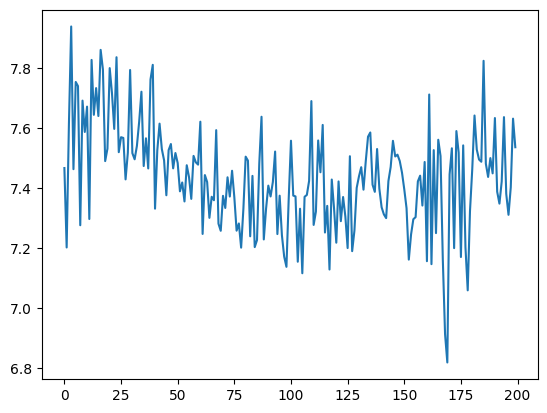

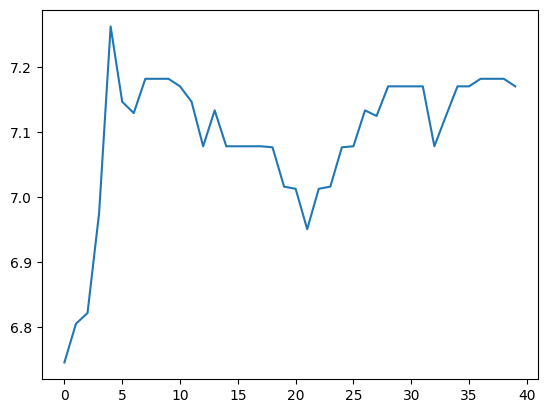

<Figure size 640x480 with 0 Axes>

In [6]:
agent.epsilon_min = 0.1
agent.epsilon_delay = 0
agent.epsilon_stop = 0
agent.epsilon_step = 1

rewards2, scores2 = agent.train(env, 200)

plt.plot(np.log10(rewards2), label="reward")
plt.figure()
plt.plot(np.log10(scores2), label = "Scores")
plt.figure()

In [2]:
import random
import os
from pathlib import Path
import numpy as np
import torch
from decimal import Decimal

from fast_evaluate import evaluate_HIV, evaluate_HIV_population


def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)

seed_everything(seed=42)
# Initialization of the agent. Replace DummyAgent with your custom agent implementation.
# Evaluate agent and write score.
score_agent = evaluate_HIV(agent=agent, nb_episode=5)
score_agent_dr = evaluate_HIV_population(agent=agent, nb_episode=20)

In [3]:
print('%.2E' % Decimal(score_agent))
print('%.2E' % Decimal(score_agent_dr))

2.37E+07
1.36E+09


In [6]:
testPatient = env_rand

state = testPatient.reset()[0]

In [9]:
type(state)

numpy.ndarray

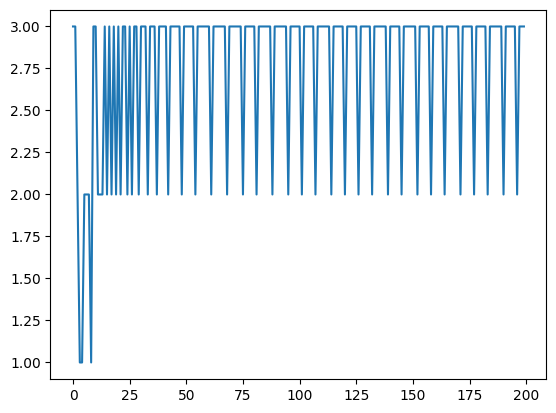

In [204]:
testPatient = env_rand
state = testPatient.reset()[0]
action_list = []
state_list = []
reward_list = []
for i in range(200):
    action = agent.act(state)
    action_list.append(action)
    state_list.append(state)
    state, reward, _, _, _ = testPatient.step(action)
    reward_list.append(reward)
plt.plot(action_list)

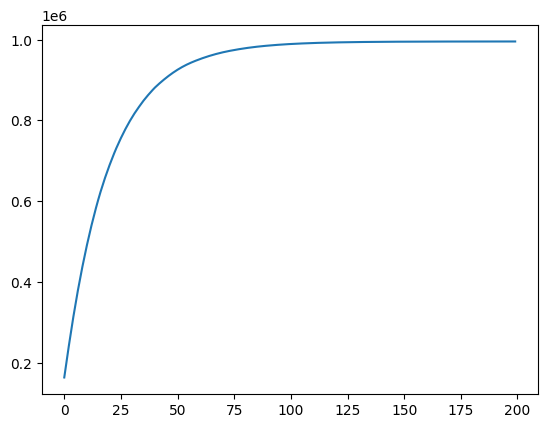

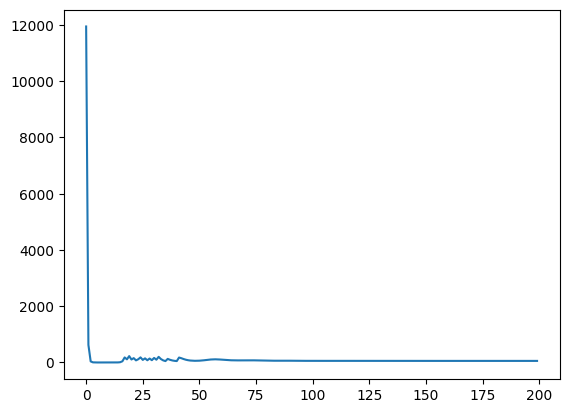

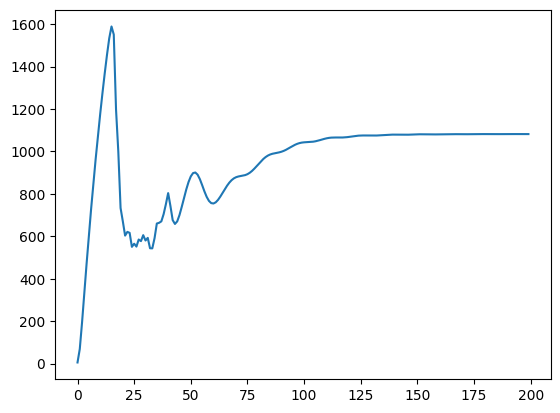

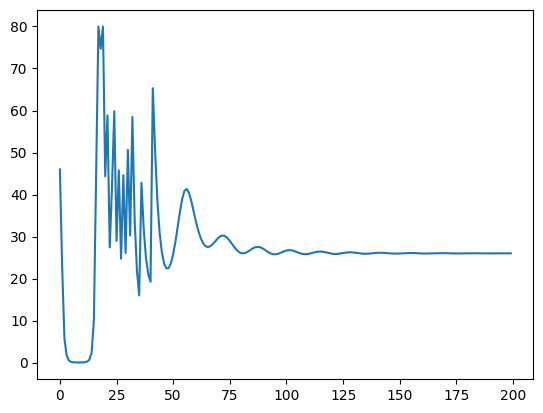

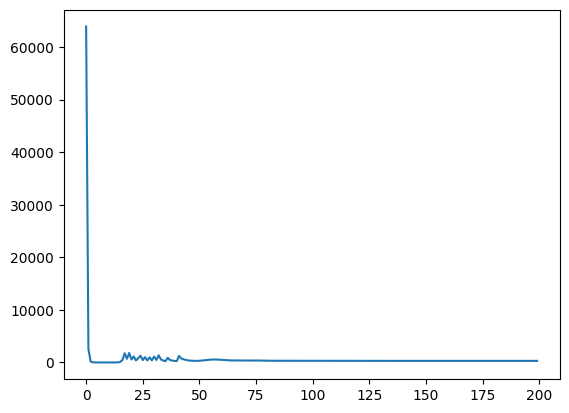

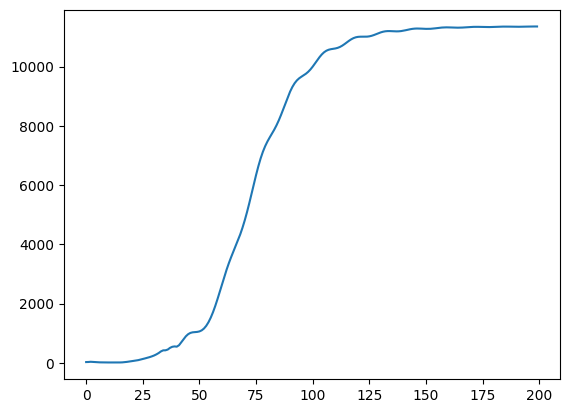

In [164]:
for i in range(6):
    plt.plot(np.array(state_list)[:,i])
    plt.show()

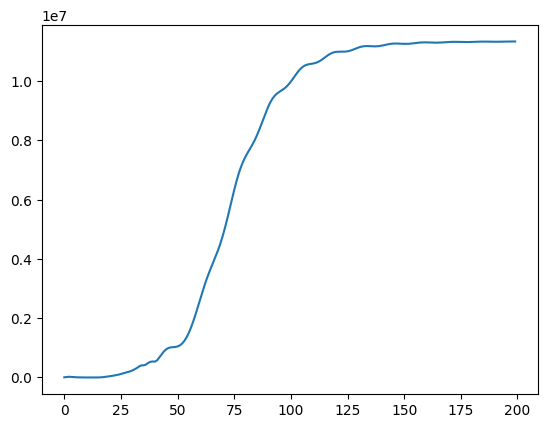

In [165]:
plt.plot(np.array(reward_list))

In [13]:
    state, reward, _, _, _ = testPatient.step(action)

In [14]:
state

array([2.39620869e+05, 7.81142493e+01, 1.66753410e+02, 9.57516809e+00,
       3.39918596e+02, 3.47320176e+01])

In [2]:
import torch

print("Is CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.device_count() > 0:
    print("CUDA device name:", torch.cuda.get_device_name(0))
else:
    print("No CUDA devices found.")


Is CUDA available: False
CUDA device count: 1


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.